In [1]:
import pandas as pd
import os
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix

from sklearn.preprocessing import label_binarize, StandardScaler, LabelEncoder, MinMaxScaler

from imblearn.over_sampling import SMOTE

import seaborn as sns
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

from joblib import dump

In [2]:
data = pd.read_csv("New Dataset/UNSW_NB15_training-set(in).csv")

In [3]:
data

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175336,175337,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,13,24,0,0,0,24,24,0,Generic,1
175337,175338,0.505762,tcp,-,FIN,10,8,620,354,33.612649,...,1,2,0,0,0,1,1,0,Shellcode,1
175338,175339,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,3,13,0,0,0,3,12,0,Generic,1
175339,175340,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,14,30,0,0,0,30,30,0,Generic,1


In [4]:
# data = data.drop(columns=['Flow ID'], errors='ignore')
data = data.replace([np.inf, -np.inf], np.nan).dropna()

In [5]:
data.columns

Index(['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label'],
      dtype='object')

In [6]:
data['attack_cat'].value_counts()

attack_cat
Normal            56000
Generic           40000
Exploits          33393
Fuzzers           18184
DoS               12264
Reconnaissance    10491
Analysis           2000
Backdoor           1746
Shellcode          1133
Worms               130
Name: count, dtype: int64

In [7]:
data = data.drop(columns=['id', 'proto', 'service', 'state', 'label'])  # Adjust as necessary
X = data.drop('attack_cat', axis=1)
y = data['attack_cat']

In [8]:
# Encode the labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

In [9]:
data

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat
0,0.121478,6,4,258,172,74.087490,252,254,1.415894e+04,8495.365234,...,1,1,1,0,0,0,1,1,0,Normal
1,0.649902,14,38,734,42014,78.473372,62,252,8.395112e+03,503571.312500,...,1,1,2,0,0,0,1,6,0,Normal
2,1.623129,8,16,364,13186,14.170161,62,252,1.572272e+03,60929.230470,...,1,1,3,0,0,0,2,6,0,Normal
3,1.681642,12,12,628,770,13.677108,62,252,2.740179e+03,3358.622070,...,1,1,3,1,1,0,2,1,0,Normal
4,0.449454,10,6,534,268,33.373826,254,252,8.561499e+03,3987.059814,...,2,1,40,0,0,0,2,39,0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175336,0.000009,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,...,24,13,24,0,0,0,24,24,0,Generic
175337,0.505762,10,8,620,354,33.612649,254,252,8.826286e+03,4903.492188,...,1,1,2,0,0,0,1,1,0,Shellcode
175338,0.000009,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,...,3,3,13,0,0,0,3,12,0,Generic
175339,0.000009,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,...,30,14,30,0,0,0,30,30,0,Generic


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [11]:
# model = RandomForestClassifier()
# model.fit(X_train, y_train)

In [12]:
# dump(model, "rf_unsw_nb15_model.joblib")

In [13]:
from joblib import load
model = load('rf_unsw_nb15_model.joblib')

In [14]:
y_pred = model.predict(X_test)

In [15]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=encoder.classes_))

[[   53    19    72   205     2     0    42     0     0     0]
 [   14    46    66   223     6     0     0     2     3     0]
 [    1     1   494  1821    18     1     6    17    11     0]
 [    1     0   685  5811    82     9    34   125    25     0]
 [    4     5    56   305  2731     3   445     5    16     0]
 [    0     1    40   116    11  7904     3     1     3     0]
 [    5     0     4   100   731     0 10311     9     9     0]
 [    0     2    99   424    10     0     1  1557     5     0]
 [    0     0    11    34    32     6     8     4   138     0]
 [    0     0     0    19     0     0     0     0     0     6]]
                precision    recall  f1-score   support

      Analysis       0.68      0.13      0.23       393
      Backdoor       0.62      0.13      0.21       360
           DoS       0.32      0.21      0.25      2370
      Exploits       0.64      0.86      0.73      6772
       Fuzzers       0.75      0.76      0.76      3570
       Generic       1.00      0

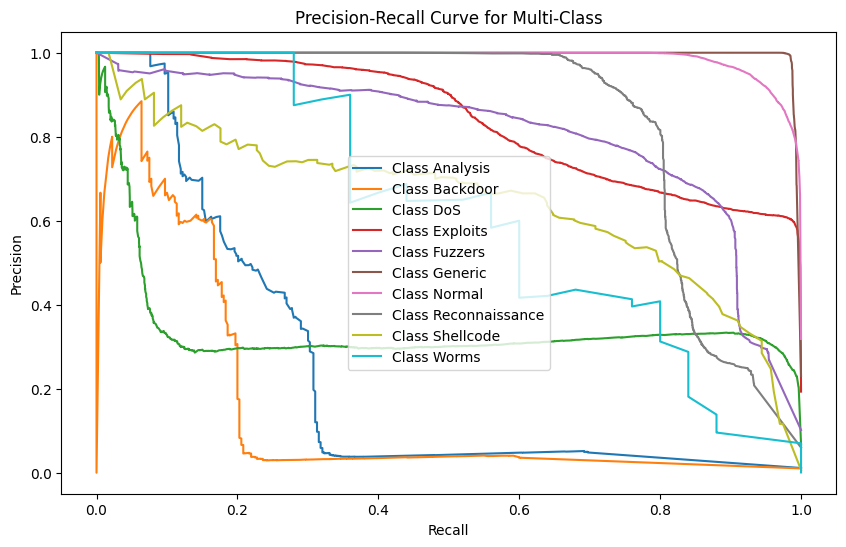

In [16]:
# Binarize the multi-class labels for one-vs-rest precision-recall calculation


# Binarize the multi-class labels for one-vs-rest precision-recall calculation
y_test_binarized = label_binarize(y_test, classes=range(len(encoder.classes_)))  # Adjust to number of classes

plt.figure(figsize=(10, 6))

# Compute Precision-Recall curve for each class
for i, class_name in enumerate(encoder.classes_):
    precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], model.predict_proba(X_test)[:, i])
    plt.plot(recall, precision, label=f"Class {class_name}")

# Add plot details
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Multi-Class")
plt.legend(loc="best")
plt.show()

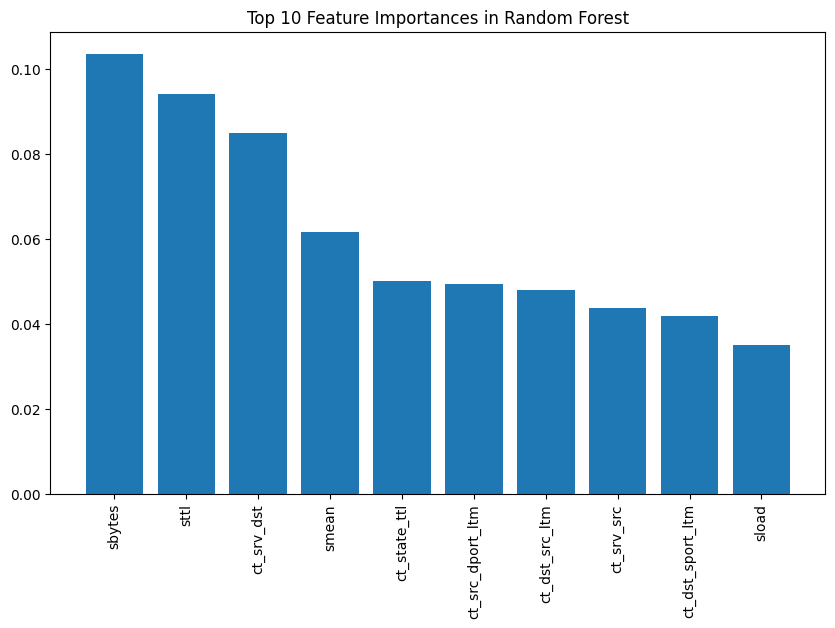

In [17]:
importances = model.feature_importances_
sorted_indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_indices[:10])), importances[sorted_indices[:10]], align="center")
plt.xticks(range(len(sorted_indices[:10])), X.columns[sorted_indices[:10]], rotation=90)
plt.title("Top 10 Feature Importances in Random Forest")
plt.show()

In [18]:
# Train Isolation Forest
iso_model = IsolationForest(contamination=0.1)
iso_model.fit(X_train)
iso_y_pred = iso_model.predict(X_test)

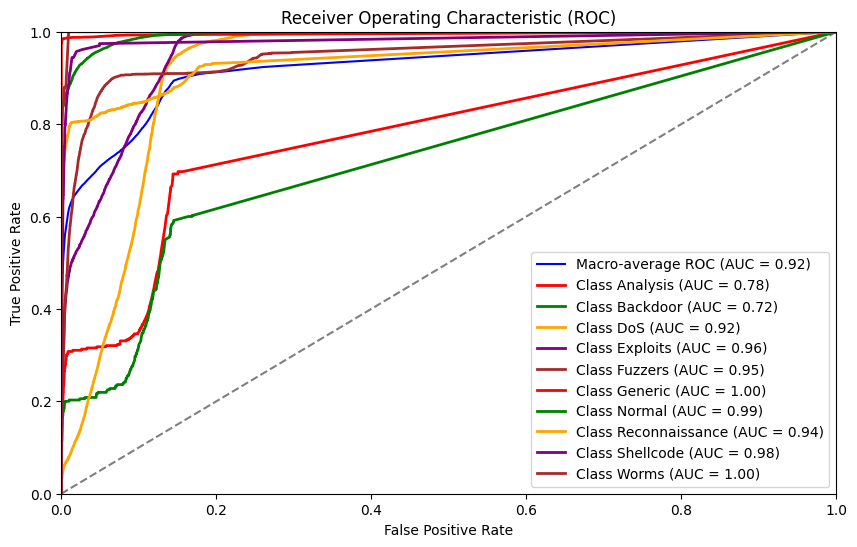

In [19]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Binarize the output labels for multi-class ROC
y_test_binarized = label_binarize(y_test, classes=np.arange(len(encoder.classes_)))
n_classes = y_test_binarized.shape[1]

# Predict probabilities
y_score = model.predict_proba(X_test)

# Compute ROC curve and ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC curve and AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes
macro_roc_auc = auc(all_fpr, mean_tpr)

# Plot the macro-average ROC curve
plt.figure(figsize=(10, 6))
plt.plot(all_fpr, mean_tpr, color='blue', label='Macro-average ROC (AUC = %0.2f)' % macro_roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Plot ROC for each class
colors = cycle(['red', 'green', 'orange', 'purple', 'brown'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='Class %s (AUC = %0.2f)' % (encoder.classes_[i], roc_auc[i]))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()